# Mount Drive + EDA



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

In [3]:
DATA_FOLDER = "/content/drive/MyDrive/() Nurse Case Challenge 2024/published_dataset"
USER_ID = "N01T1"
keypoint_csv = DATA_FOLDER + '/keypoints/{}_keypoint.csv'.format(USER_ID)
ann_csv = DATA_FOLDER + '/ann/{}_ann.csv'.format(USER_ID)

TEST_ID = "N02T1"
test_keypoint_csv = DATA_FOLDER + '/keypoints/{}_keypoint.csv'.format(TEST_ID)
test_ann_csv = DATA_FOLDER + '/ann/{}_ann.csv'.format(TEST_ID)

In [4]:
FS = 30 # Sampling Rate
TOTAL_CLASSES = 9

In [5]:
def load_data(kpc,annc):
  kp_df = pd.read_csv(kpc)
  kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('^Unnamed')]

  ann_df = pd.read_csv(annc)
  ann_df = ann_df.loc[:, ~ann_df.columns.str.contains('^Unnamed')]

  return kp_df, ann_df

In [6]:
kp_df, ann_df = load_data(keypoint_csv,ann_csv)
test_kp_df, test_ann_df = load_data(test_keypoint_csv, test_ann_csv)

In [7]:
kp_df.head(5)

,nose_x,nose_y,nose_conf,left_eye_x,left_eye_y,left_eye_conf,right_eye_x,right_eye_y,right_eye_conf,left_ear_x,...,left_knee_conf,right_knee_x,right_knee_y,right_knee_conf,left_ankle_x,left_ankle_y,left_ankle_conf,right_ankle_x,right_ankle_y,right_ankle_conf
0,0.0,0.0,0.002434,0.0,0.0,0.002522,0.0,0.0,0.002642,0.0,...,0.236206,0.0,0.0,0.063232,0.0,0.0,0.028549,0.0,0.0,0.011375
1,0.0,0.0,0.002323,0.0,0.0,0.002562,0.0,0.0,0.002632,0.0,...,0.267334,0.0,0.0,0.076843,0.0,0.0,0.032593,0.0,0.0,0.013329
2,0.0,0.0,0.002287,0.0,0.0,0.002472,0.0,0.0,0.002581,0.0,...,0.240112,0.0,0.0,0.063965,0.0,0.0,0.028976,0.0,0.0,0.011467
3,0.0,0.0,0.002415,0.0,0.0,0.002541,0.0,0.0,0.002602,0.0,...,0.237915,0.0,0.0,0.064880,0.0,0.0,0.028763,0.0,0.0,0.011597
4,0.0,0.0,0.002398,0.0,0.0,0.002512,0.0,0.0,0.002581,0.0,...,0.229248,0.0,0.0,0.060760,0.0,0.0,0.027695,0.0,0.0,0.010986


In [8]:
ann_df.head(5)

,start_time,stop_time,annotation_str,annotation
0,0,14.0,others,8
1,14,43.0,catheter preparation,0
2,43,46.0,temporal removement of an artificial airway,1
3,46,56.0,suctioning phlegm,2
4,56,59.0,refitting the artificial airway,3


In [9]:
keypoint_position = "left_elbow"

KEYPOINTS_DICT = {"nose": 0,
                  "left_eye": 1,
                  "right_eye":2,
                  "left_ear":3,
                  "right_ear":4,
                  "left_shoulder":5,
                  "right_shoulder":6,
                  "left_elbow":7,
                  "right_elbow":8,
                  "left_wrist":9,
                  "right_wrist":10,
                  "left_hip":11,
                  "right_hip":12,
                  "left_knee":13,
                  "right_knee":14,
                  "left_ankle":15,
                  "right_ankle":16}

values = np.array(kp_df)[:,int(KEYPOINTS_DICT[keypoint_position]*3):int(KEYPOINTS_DICT[keypoint_position]*3+3)]

<Figure size 3000x1500 with 0 Axes>

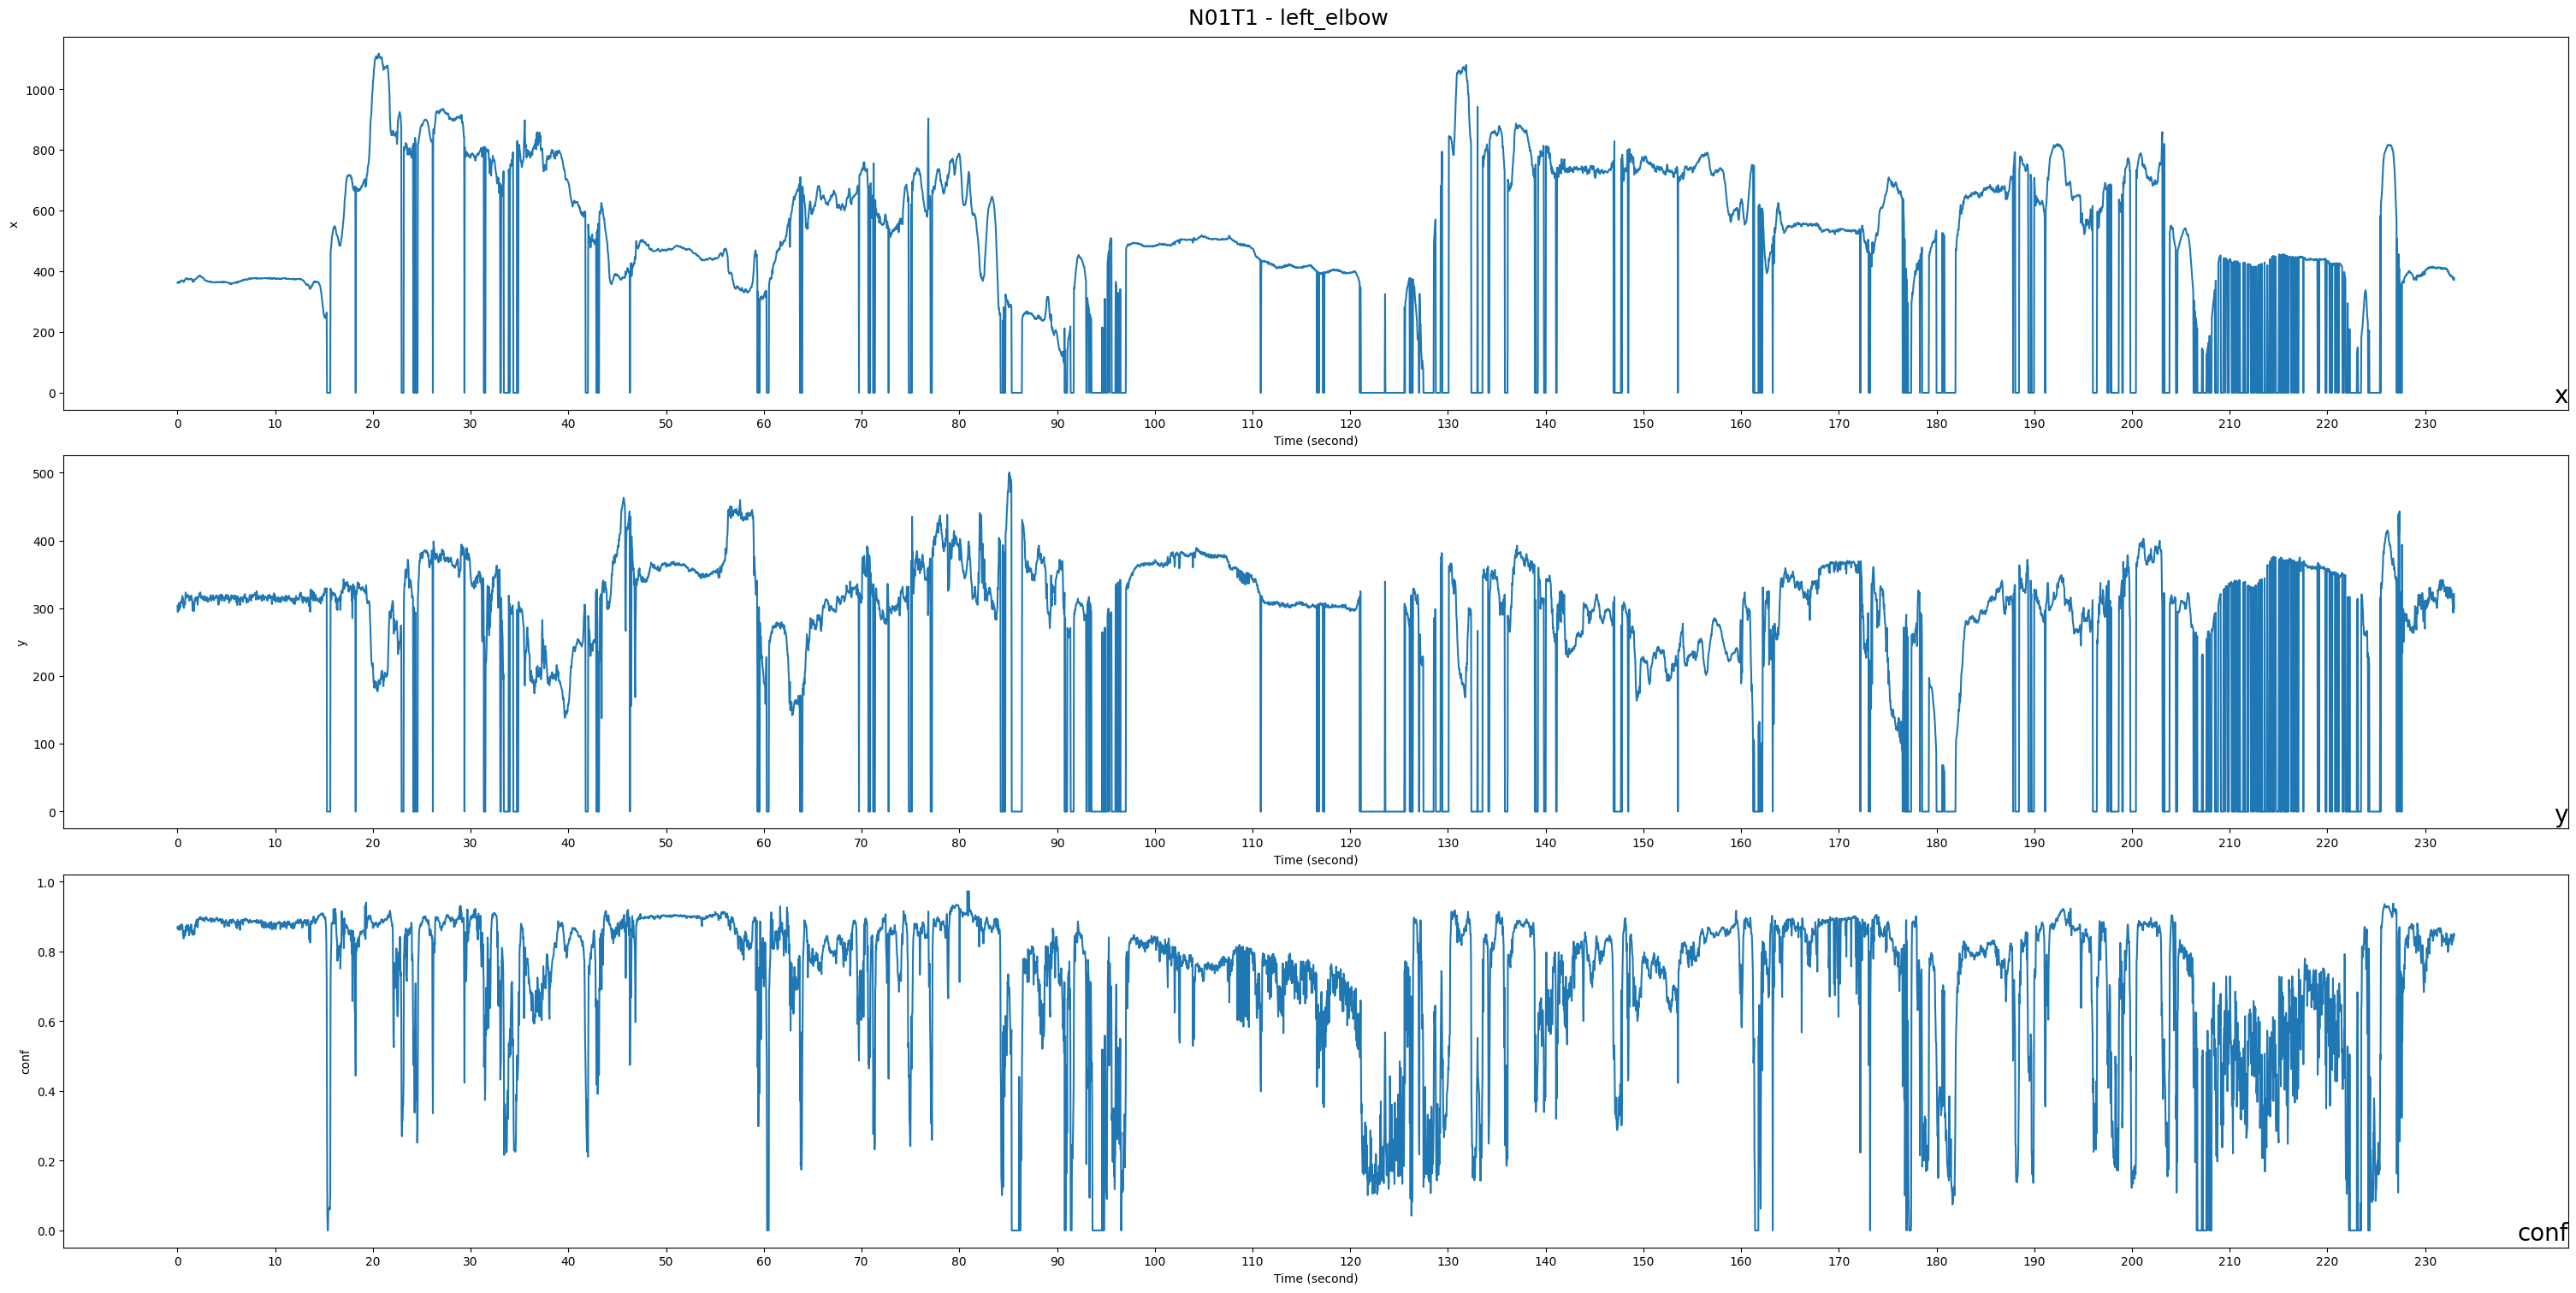

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,15))
fig, axs = plt.subplots(3, 1, figsize=(30,15),  layout="constrained")
cols_name = ["x", "y", "conf"]
axs
for x in range(3):
    axs[x].plot(values[:, x])
    axs[x].set_title(cols_name[x], y=0, loc='right', fontsize=20)
    axs[x].set_xlabel("Time (second)")
    axs[x].set_ylabel(cols_name[x])

x_ticks = np.arange(0, len(values), 10*FS)
x_ticklabels = np.arange(0, len(x_ticks))*10
plt.setp(axs, xticks=x_ticks, xticklabels=x_ticklabels)
fig.suptitle('{} - {}'.format(USER_ID, keypoint_position), size=18)
plt.show()

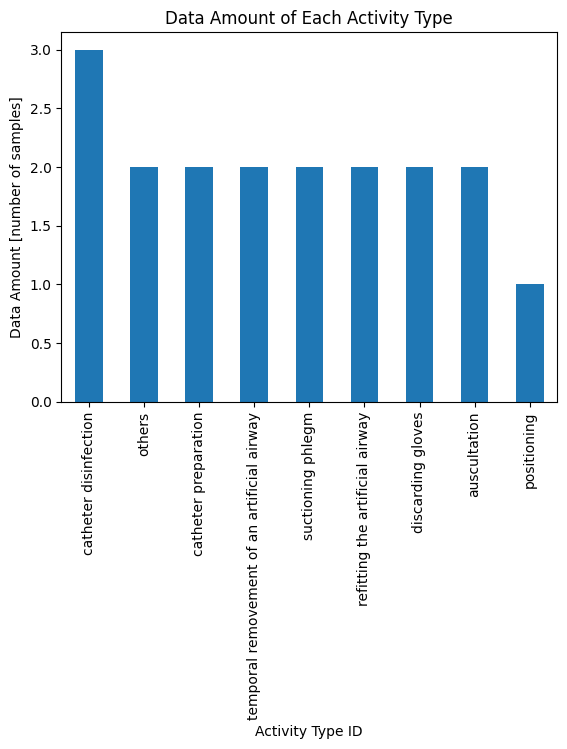

In [11]:
tmp_data_count = ann_df['annotation_str'].value_counts()
tmp_data_count.plot(kind='bar')
plt.title('Data Amount of Each Activity Type')
plt.xlabel('Activity Type ID')
plt.ylabel('Data Amount [number of samples]')

plt.show()

del tmp_data_count

# 2. Prediction

## Preprocessing

In [12]:
# Remove redundant data -> ankles and knees and conf
def remove_redundant(kp_df):
  kp_df = kp_df.loc[:,~kp_df.columns.str.contains('conf|left_ankle|right_ankle|left_knee|right_knee',regex = True)]

  return kp_df

In [13]:
kp_df = remove_redundant(kp_df)
test_kp_df = remove_redundant(test_kp_df)

In [14]:
kp_df.head()

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,412.50,631.87500,0.0,0.0,279.5,675.9375,22.1250,693.28125
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,399.50,570.00000,0.0,0.0,282.0,661.8750,21.3750,680.15625
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,414.00,640.78125,0.0,0.0,279.5,671.2500,20.3125,688.12500
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,410.75,607.96875,0.0,0.0,279.5,675.0000,20.8125,692.81250
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,413.25,623.43750,0.0,0.0,280.0,681.5625,20.3125,698.90625


In [15]:
# Data Smoothing

SMOOTH_LEN = 3 #seconds

def smoother(kp_col):
  zero_idx = np.flatnonzero(kp_col==0)
  split_idx = np.split(zero_idx,np.flatnonzero(np.diff(zero_idx)>1)+1)

  for each_split_idx in split_idx:
    if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN*FS:
      continue
    xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
    fp = kp_col[xp]
    interp_kp = np.interp(each_split_idx, xp, fp)
    kp_col[each_split_idx] = interp_kp
  return kp_col

for i in range(len(kp_df.columns)):

  kp_df.iloc[:,i] = smoother(np.array(kp_df.iloc[:,i]))
  test_kp_df.iloc[:,i] = smoother(np.array(test_kp_df.iloc[:,i]))

<Figure size 3000x1500 with 0 Axes>

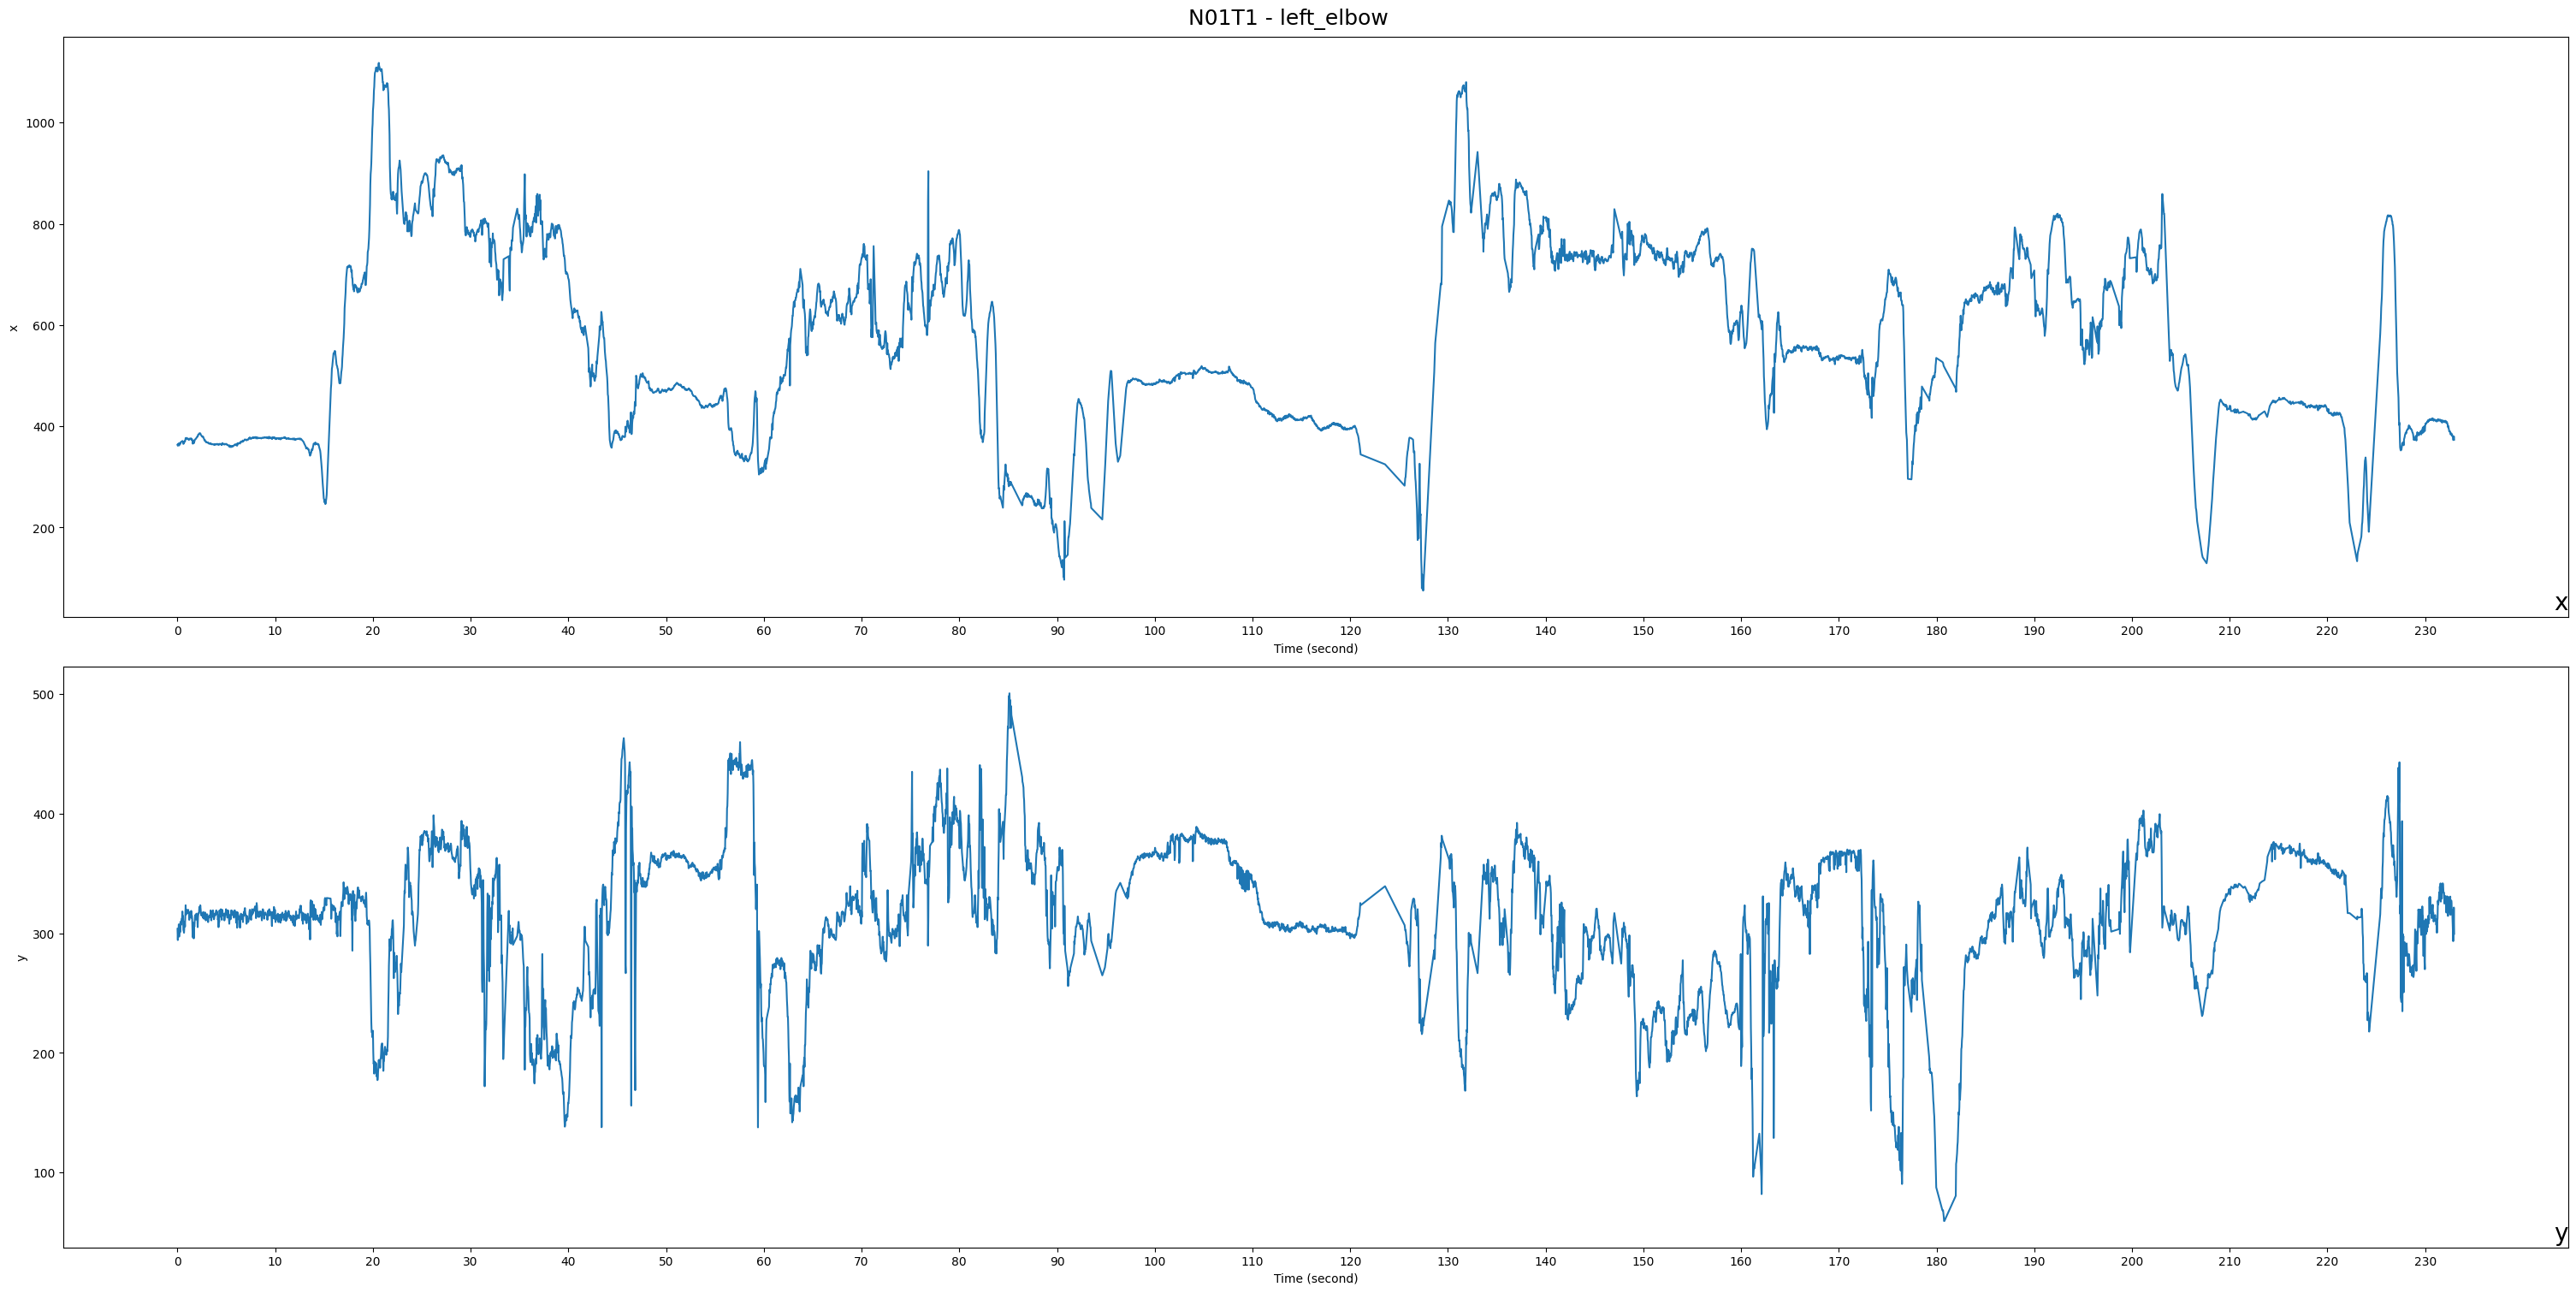

In [16]:
keypoint_position = "left_elbow"  # choose keypoint you want to visualize
values = np.array(kp_df)[:, int(KEYPOINTS_DICT[keypoint_position]*2):int(KEYPOINTS_DICT[keypoint_position]*2 + 2)]

fig = plt.figure(figsize=(30,15))
fig, axs = plt.subplots(2, 1, figsize=(30,15),  layout="constrained")
cols_name = ["x", "y"]
for x in range(2):
    axs[x].plot(values[:, x])
    axs[x].set_title(cols_name[x], y=0, loc='right', fontsize=20)
    axs[x].set_xlabel("Time (second)")
    axs[x].set_ylabel(cols_name[x])

x_ticks = np.arange(0, len(values), 10*FS)
x_ticklabels = np.arange(0, len(x_ticks))*10
plt.setp(axs, xticks=x_ticks, xticklabels=x_ticklabels)
fig.suptitle('{} - {}'.format(USER_ID, keypoint_position), size=18)
plt.show()

##Segmentation

In [17]:
def segment(data, max_time, sub_window_size, stride_size):
    sub_windows = np.arange(sub_window_size)[None, :] + np.arange(0, max_time, stride_size)[:, None]

    row, col = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))

    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]

    return data[sub_windows]

##Feature Extraction

In [18]:
import scipy

def extract_feature(data, fs):
    mean_ft = np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    features = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft]).T.flatten()
    features = np.nan_to_num(features)
    return features

In [19]:
WINDOW_SIZE = 2 # seconds
OVERLAP_RATE = 0.5 * WINDOW_SIZE # overlap 50% of window size

In [20]:
# Processing training data
all_feature = []
all_label = []

for i in range(len(ann_df)):
  # seg -> individually separates each task from annotations (e.g 14 sec for no. 8 task = 14x30fps = 420)
  seg = kp_df.loc[int(ann_df['start_time'][i]*FS): int(ann_df['stop_time'][i]*FS)]
  # print(f'{i}:{seg.shape}')
  seg_label = ann_df["annotation"].iloc[i]
  if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
      # Segment keypoint data by WINDOW_SIZE and OVERLAP_RATE
      ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
      # print(ws_seg.shape)
      # Calculate features from each segment of keypoint data
      feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]

      #extract_features returns [182,] for each window
      #By default7 fetaure extraction (mean, median, etc) across 26 parameters -> 26x7 = 182
      # feature_seg1115 = np.array(feature_seg)
      # print(feature_seg1115.shape)

      all_feature.extend(feature_seg)
      all_label.extend([int(seg_label)]*len(ws_seg))

In [21]:
# Processing test data
test_all_feature = []
test_all_label = []

for i in range(len(test_ann_df)):
  seg = test_kp_df.loc[int(test_ann_df['start_time'][i]*FS): int(test_ann_df['stop_time'][i]*FS)]
  seg_label = test_ann_df["annotation"].iloc[i]
  if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
      # Segment keypoint data by WINDOW_SIZE and OVERLAP_RATE
      ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

      # Calculate features from each segment of keypoint data
      feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]

      test_all_feature.extend(feature_seg)
      test_all_label.extend([int(seg_label)]*len(ws_seg))

## Training


In [22]:
print("Total samples of training data: {}".format(len(all_feature)))
print("Total samples of testing data: {}".format(len(test_all_feature)))
print("Total features: {}".format(np.shape(all_feature)[1]))

Total samples of training data: 215
Total samples of testing data: 257
Total features: 182


In [23]:
from sklearn.ensemble import RandomForestClassifier

model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)
model_ml.fit(all_feature, all_label)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

## Evaluation


              precision    recall  f1-score   support

           0       0.51      0.86      0.64        76
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        16
           3       0.20      0.33      0.25         3
           4       0.11      0.04      0.06        50
           5       0.00      0.00      0.00         5
           6       0.12      0.14      0.13         7
           7       0.78      0.10      0.17        71
           8       0.00      0.00      0.00        25

    accuracy                           0.30       257
   macro avg       0.19      0.16      0.14       257
weighted avg       0.39      0.30      0.26       257



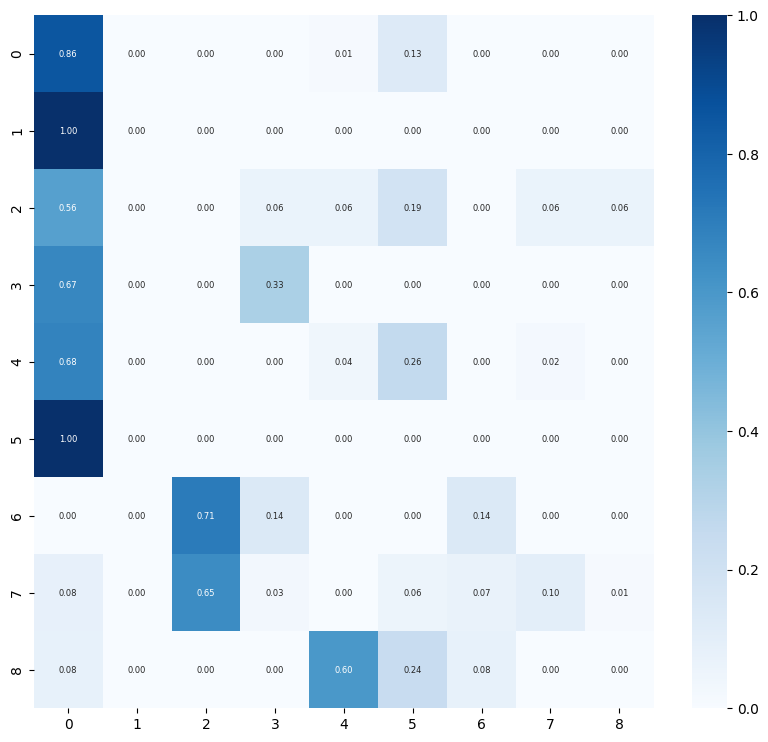

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_predict = model_ml.predict(test_all_feature)
print(classification_report(test_all_label, y_predict))
cm = confusion_matrix(test_all_label, y_predict, labels=np.unique(test_all_label))
cm_norm = cm / np.sum(cm, axis=1, keepdims=True)
plt.figure(figsize=(10, 9))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSES), xticklabels=np.arange(TOTAL_CLASSES))
plt.show()

##GenAI Example

### Calculate Joint Angles

In [62]:
def cal_angle(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle
def mid_point(a,b):
  a = (np.array(a))
  b = (np.array(b))
  mid = (np.subtract(a,b))/2
  return mid

def extract_joint_angles(kp_data, steps=2):
    # steps = 2 if kp_data is removed conf columns
    # steps = 3 if kp_data has conf columns
    left_elbow_shoulder_hip = np.asarray([cal_angle(kp_data[i, 7*steps:(7*steps+2)], kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 11*steps:(11*steps+2)])
                                          for i in range(len(kp_data))])
    left_elbow_shoulder_hip = np.nan_to_num(left_elbow_shoulder_hip)
    right_elbow_shoulder_hip = np.asarray([cal_angle(kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 12*steps:(12*steps+2)])
                                            for i in range(len(kp_data))])
    right_elbow_shoulder_hip = np.nan_to_num(right_elbow_shoulder_hip)
    left_wrist_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 9*steps:(9*steps+2)], kp_data[i, 7*steps:(7*steps+2)], kp_data[i, 5*steps:(5*steps + 2)])
                                            for i in range(len(kp_data))])
    left_wrist_elbow_shoulder = np.nan_to_num(left_wrist_elbow_shoulder)
    right_wrist_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 10*steps:(10*steps+2)], kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)])
                                              for i in range(len(kp_data))])
    right_wrist_elbow_shoulder = np.nan_to_num(right_wrist_elbow_shoulder)


    right_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 5*steps:(5*steps+2)])
                                              for i in range(len(kp_data))])
    right_elbow_shoulder = np.nan_to_num(right_elbow_shoulder)
    left_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 7*steps:(7*steps+2)])
                                              for i in range(len(kp_data))])
    left_elbow_shoulder = np.nan_to_num(left_elbow_shoulder)

    # < : right shoulder, nose, left shoulder
    right_shoulder_nose_left_shoulder = np.asarray([cal_angle(kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 0*steps:(0*steps+2)], kp_data[i, 5*steps:(5*steps+2)])
                                              for i in range(len(kp_data))])
    right_shoulder_nose_left_shoulder = np.nan_to_num(right_shoulder_nose_left_shoulder)


    # Calculate center of hip
    h1 = [kp_data[i, 11*steps:(11*steps+2)] for i in range(len(kp_data))]
    h2 = [kp_data[i, 12*steps:(12*steps+2)] for i in range(len(kp_data))]
    hip_center = mid_point(h1,h2)

    # < : hip center, left shoulder, elbow
    hip_center_left_shoulder_elbow = np.asarray([cal_angle(hip_center[i] , kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 7*steps:(7*steps+2)])
                                              for i in range(len(kp_data))])
    hip_center_left_shoulder_elbow = np.nan_to_num(hip_center_left_shoulder_elbow)
    # < : hip center, right shoulder, elbow
    hip_center_right_shoulder_elbow = np.asarray([cal_angle(mid_point(kp_data[i, 11*steps:(11*steps+2)],kp_data[i, 12*steps:(12*steps+2)]) , kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 8*steps:(8*steps+2)])
                                              for i in range(len(kp_data))])
    hip_center_right_shoulder_elbow = np.nan_to_num(hip_center_right_shoulder_elbow)



    joint_angles = np.array([left_elbow_shoulder_hip, right_elbow_shoulder_hip, left_wrist_elbow_shoulder, right_wrist_elbow_shoulder, right_elbow_shoulder, left_elbow_shoulder, right_shoulder_nose_left_shoulder, hip_center_left_shoulder_elbow,hip_center_right_shoulder_elbow]).T

    return joint_angles

### Calculate Velocity, Acceleration, Jerk

In [71]:
def extract_velocity(kp_data):
    velocity = np.diff(kp_data, axis=0)
    return velocity
def extract_acceleration(kp_data):
    velocity = extract_velocity(kp_data)
    acc = np.diff(velocity,axis=0)
    return acc
def extract_jerk(kp_data):
    acc = extract_acceleration(kp_data)
    jerk = np.diff(acc,axis=0)
    return jerk

### Calculate Joint Distance

In [64]:
def cal_distance(a,b):
  distance = np.sqrt(np.sum((b-a)**2))
  return distance

def extract_joint_distances(kp_data, steps=2):
    # steps = 2 if kp_data is removed conf columns
    # steps = 3 if kp_data has conf columns

    # -- : right shoulder, wrist
    d_right_shoulder_wrist = np.asarray([cal_distance(kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 10*steps:(10*steps+2)])
                                          for i in range(len(kp_data))])
    d_right_shoulder_wrist = np.nan_to_num(d_right_shoulder_wrist)
    # -- : left shoulder, wrist
    d_left_shoulder_wrist = np.asarray([cal_distance(kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 9*steps:(9*steps+2)])
                                          for i in range(len(kp_data))])
    d_left_shoulder_wrist = np.nan_to_num(d_left_shoulder_wrist)

    #Calculate hip center
    h1 = [kp_data[i, 11*steps:(11*steps+2)] for i in range(len(kp_data))]
    h2 = [kp_data[i, 12*steps:(12*steps+2)] for i in range(len(kp_data))]
    hip_center = mid_point(h1,h2)

    # -- : hip center, right elbow
    d_hipc_right_elbow = np.asarray([cal_distance(hip_center[i], kp_data[i, 8*steps:(8*steps+2)])
                                          for i in range(len(kp_data))])
    d_hipc_right_elbow = np.nan_to_num(d_hipc_right_elbow)
    # -- : hip center, left elbow
    d_hipc_left_elbow = np.asarray([cal_distance(hip_center[i], kp_data[i, 7*steps:(7*steps+2)])
                                          for i in range(len(kp_data))])
    d_hipc_left_elbow = np.nan_to_num(d_hipc_left_elbow)
    # -- : hip center, right wrist
    d_hipc_right_wrist = np.asarray([cal_distance(hip_center[i], kp_data[i, 10*steps:(10*steps+2)])
                                          for i in range(len(kp_data))])
    d_hipc_right_wrist = np.nan_to_num(d_hipc_right_wrist)
    # -- : hip center, left wrist
    d_hipc_left_wrist = np.asarray([cal_distance(hip_center[i], kp_data[i, 9*steps:(9*steps+2)])
                                          for i in range(len(kp_data))])
    d_hipc_left_wrist = np.nan_to_num(d_hipc_left_wrist)
    # -- : right wrist, left wrist
    d_right_wrist_left_wrist = np.asarray([cal_distance(kp_data[i, 10*steps:(10*steps+2)], kp_data[i, 9*steps:(9*steps+2)])
                                          for i in range(len(kp_data))])
    d_right_wrist_left_wrist = np.nan_to_num(d_right_wrist_left_wrist)
    # -- : right hip, left hip
    d_right_hip_left_hip = np.asarray([cal_distance(kp_data[i, 12*steps:(12*steps+2)], kp_data[i, 11*steps:(11*steps+2)])
                                          for i in range(len(kp_data))])
    d_right_hip_left_hip = np.nan_to_num(d_right_hip_left_hip)
    # -- : right hip, right wrist
    d_right_hip_right_wrist = np.asarray([cal_distance(kp_data[i, 12*steps:(12*steps+2)], kp_data[i, 10*steps:(10*steps+2)])
                                          for i in range(len(kp_data))])
    d_right_hip_right_wrist =  np.nan_to_num(d_right_hip_right_wrist)
    # -- : left hip, left wrist
    d_left_hip_left_wrist = np.asarray([cal_distance(kp_data[i, 11*steps:(11*steps+2)], kp_data[i, 9*steps:(9*steps+2)])
                                          for i in range(len(kp_data))])
    d_left_hip_left_wrist = np.nan_to_num(d_left_hip_left_wrist)


    # Calculate Spine joint
    s1 = [kp_data[i, 5*steps:(5*steps+2)] for i in range(len(kp_data))]
    s2 = [kp_data[i, 6*steps:(6*steps+2)] for i in range(len(kp_data))]
    spine = mid_point(s1,s2)


    # Calculate distance between hip center to spine joint -> relatively invariant when performing activities
    norm_distance = np.asarray([cal_distance(hip_center[i], spine[i])
                                          for i in range(len(kp_data))])
    norm_distance = (np.nan_to_num(norm_distance)).reshape(-1)

    joint_distances = np.array([d_right_shoulder_wrist, d_left_shoulder_wrist, d_hipc_right_elbow, d_hipc_left_elbow, d_hipc_right_wrist, d_hipc_left_wrist, d_right_wrist_left_wrist, d_right_hip_left_hip, d_right_hip_right_wrist, d_left_hip_left_wrist]).T

    # Normalize the joint distances
    normalized_joint_distances = joint_distances/norm_distance[:,None]

    return joint_distances






### Extract Features

In [72]:
# Processing training data
all_feature = []
all_label = []

for i in range(len(ann_df)):
  seg = kp_df.loc[int(ann_df['start_time'][i]*FS): int(ann_df['stop_time'][i]*FS)]
  seg_label = ann_df["annotation"].iloc[i]
  if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
      # Calculate joint angles from keypoint data
      joint_angles = extract_joint_angles(np.array(seg))

      # Segment keypoint data and joint angles by WINDOW_SIZE and OVERLAP_RATE
      ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
      joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS,
                                        stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))


      # Calculate velocity, acceleration, jerk from each segment of keypoint data
      velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
      acc_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
      jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

      # Calculate features from each segment of keypoint data, joint angles and velocity
      feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]
      feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in
                                  range(len(joint_angles_seg))]
      feature_velocity_seg = [extract_feature(extract_velocity(ws_seg[i]), FS) for i in range(len(ws_seg))]
      feature_acc_seg = [extract_feature(extract_acceleration(ws_seg[i]), FS) for i in range(len(ws_seg))]
      feature_jerk_seg = [extract_feature(extract_jerk(ws_seg[i]), FS) for i in range(len(ws_seg))]

      # Concatenate all features
      feature_seg = np.concatenate([feature_seg, feature_joint_angles_seg, feature_velocity_seg, feature_acc_seg, feature_jerk_seg], axis=1)

      all_feature.extend(feature_seg)
      all_label.extend([int(seg_label)]*len(ws_seg))

In [74]:
# Processing test data
test_all_feature = []
test_all_label = []

for i in range(len(test_ann_df)):
  seg = test_kp_df.loc[int(test_ann_df['start_time'][i]*FS): int(test_ann_df['stop_time'][i]*FS)]
  seg_label = test_ann_df["annotation"].iloc[i]
  if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):

      # Calculate joint angles from keypoint data
      joint_angles = extract_joint_angles(np.array(seg))

      # Segment keypoint data and joint angles by WINDOW_SIZE and OVERLAP_RATE
      ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
      joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS,
                                        stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

      # Calculate velocity, acceleration, jerk from each segment of keypoint data
      velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
      acc_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
      jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

      # Calculate features from each segment of keypoint data, joint angles and velocity
      feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]
      feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in
                                  range(len(joint_angles_seg))]
      feature_velocity_seg = [extract_feature(extract_velocity(ws_seg[i]), FS) for i in range(len(ws_seg))]
      feature_acc_seg = [extract_feature(extract_acceleration(ws_seg[i]), FS) for i in range(len(ws_seg))]
      feature_jerk_seg = [extract_feature(extract_jerk(ws_seg[i]), FS) for i in range(len(ws_seg))]

      # Concatenate all features
      feature_seg = np.concatenate([feature_seg, feature_joint_angles_seg, feature_velocity_seg, feature_acc_seg, feature_jerk_seg], axis=1)

      test_all_feature.extend(feature_seg)
      test_all_label.extend([int(seg_label)]*len(ws_seg))

###Training

In [75]:
print("Total samples of training data: {}".format(len(all_feature)))
print("Total samples of testing data: {}".format(len(test_all_feature)))
print("Total features: {}".format(np.shape(test_all_feature)[1]))

Total samples of training data: 215
Total samples of testing data: 257
Total features: 791


In [76]:
from sklearn.ensemble import RandomForestClassifier

model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)
model_ml.fit(all_feature, all_label)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

### Evaluation

              precision    recall  f1-score   support

           0       0.51      0.96      0.67        76
           1       0.00      0.00      0.00         4
           2       0.04      0.12      0.06        16
           3       0.00      0.00      0.00         3
           4       1.00      0.04      0.08        50
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         7
           7       0.63      0.17      0.27        71
           8       0.94      0.68      0.79        25

    accuracy                           0.41       257
   macro avg       0.35      0.22      0.21       257
weighted avg       0.61      0.41      0.37       257



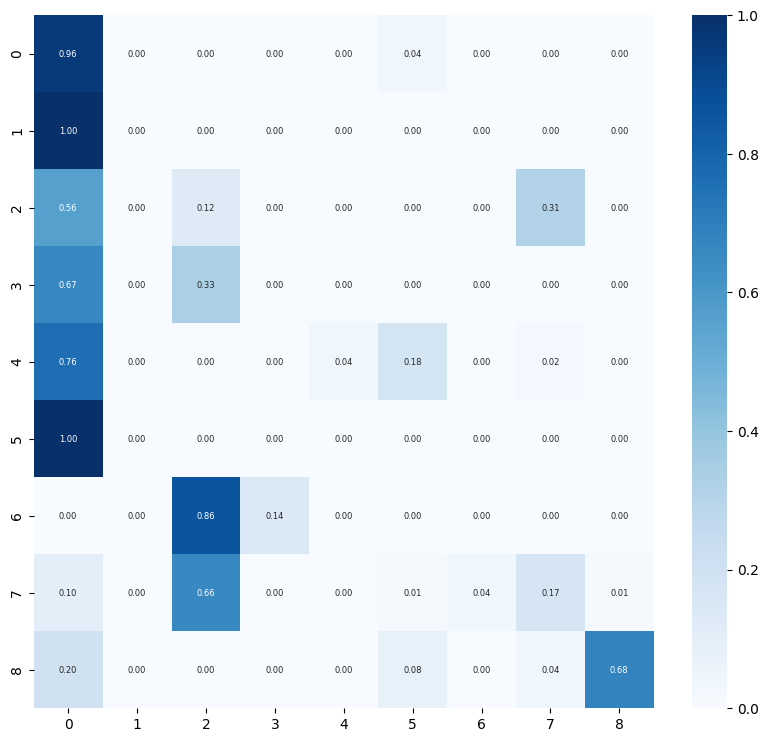

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_predict = model_ml.predict(test_all_feature)
print(classification_report(test_all_label, y_predict))
cm = confusion_matrix(test_all_label, y_predict, labels=np.unique(test_all_label))
cm_norm = cm / np.sum(cm, axis=1, keepdims=True)
plt.figure(figsize=(10, 9))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSES), xticklabels=np.arange(TOTAL_CLASSES))
plt.show()

#Submission

In [ ]:
TEST_ID = ["N03T1", "N03T2",
           "N05T1", "N05T2",
           "N09T1", "N09T2",
           "S06T1", "S06T2",
           "S04T1", "S04T2",
           "S12T1", "S12T2",]
SUBMISSION_CSV = "submission.csv"

In [ ]:
def generate_timestamp(len_file):
    time_intervals = []
    for i in range(len_file):
        minutes, seconds = divmod(i, 60)
        start_time = f"{int(minutes):02d}:{int(seconds):02d}"
        minutes, seconds = divmod(i+1, 60)
        end_time = f"{int(minutes):02d}:{int(seconds):02d}"
        time_interval = f"{start_time} - {end_time}"
        time_intervals.append(time_interval)
    return time_intervals

In [ ]:
submission = pd.DataFrame(columns=['subjectID', 'timestamp', 'activityID'])

for user_id in TEST_ID:
    keypoint_csv = DATA_FOLDER + "/keypoints/{}_keypoint.csv".format(user_id)
    ann_csv = DATA_FOLDER + "/ann/{}_ann.csv".format(user_id)
    kp_df = pd.read_csv(keypoint_csv)
    kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('^Unnamed')]
    kp_df = remove_redundant(kp_df)
    for i, kp_name in enumerate(kp_df.columns):
          kp_df.iloc[:, i] = smoother(np.array(kp_df.iloc[:, i]))

    # Calculate joint angles from keypoint data
    joint_angles = extract_joint_angles(np.array(kp_df))
    # Segment keypoint data and joint angles by WINDOW_SIZE without OVERLAP_RATE
    ws_seg = segment(np.array(kp_df), max_time=len(kp_df), sub_window_size=WINDOW_SIZE * FS, stride_size=int(WINDOW_SIZE * FS))
    joint_angles_seg = segment(joint_angles, max_time=len(kp_df), sub_window_size=WINDOW_SIZE * FS,
                                      stride_size=int(WINDOW_SIZE * FS))
    # Calculate velocity from each segment of keypoint data
    velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
    # Calculate features from each segment of keypoint data, joint angles and velocity
    feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]
    feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in
                                range(len(joint_angles_seg))]

    feature_velocity_seg = [extract_feature(extract_velocity(ws_seg[i]), FS) for i in range(len(ws_seg))]

    # Concatenate all features
    feature_seg = np.concatenate([feature_seg, feature_joint_angles_seg, feature_velocity_seg], axis=1)

    # Predict
    y_predict = model_ml.predict(feature_seg)

    # Get prediction in each second
    activityID = np.repeat(y_predict, WINDOW_SIZE)

    # Add result in submission dataframe
    subjectID = [user_id]*len(activityID)
    timestamp = generate_timestamp(len(activityID))

    new_data = {'subjectID': subjectID, 'timestamp': timestamp, 'activityID': activityID}
    new_df = pd.DataFrame(new_data)

    submission = pd.concat([submission, new_df], ignore_index=True)

In [ ]:
submission.head()

In [ ]:
# Export submission dataframe into csv
submission.to_csv(SUBMISSION_CSV, index=False)